In [363]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import glob
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [2]:
filenames = glob.glob('Datathon*.csv')

In [268]:
pre_dat = pd.DataFrame({})
for ind, filename in enumerate(filenames):
    print(ind)
    tmp_dat = pd.read_csv(filename)
    pre_dat = pre_dat.append(tmp_dat)    
pre_dat.columns = ['BET_ID', 'BET_TRANS_ID', 'MATCH_BET_ID', 'ACCOUNT_ID',
       'COUNTRY_OF_RESIDENCE_NAME', 'PARENT_EVENT_ID', 'EVENT_ID', 'MATCH',
       'EVENT_NAME', 'EVENT_DT', 'OFF_DT', 'BID_TYP', 'STATUS_ID',
       'PLACED_DATE', 'TAKEN_DATE', 'SETTLED_DATE', 'CANCELLED_DATE',
       'SELECTION_NAME', 'PERSISTENCE_TYPE', 'BET_PRICE', 'PRICE_TAKEN',
       'INPLAY_BET', 'BET_SIZE', 'PROFIT_LOSS']
peek_dat = pd.read_csv('DSMDatathon_samplefile.txt', sep='\t')
pre_dat = peek_dat.append(pre_dat)

0
1

/Users/feizhan/miniconda/envs/py3_env/lib/python3.4/site-packages/pandas/io/parsers.py:1170: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)
/Users/feizhan/miniconda/envs/py3_env/lib/python3.4/site-packages/pandas/io/parsers.py:1170: DtypeWarning: Columns (14,16) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)



2
3
4


In [269]:
pre_dat.loc[:, 'BID_TYP'] = pre_dat.loc[:, 'BID_TYP'].str.strip(' ')
pre_dat.loc[:, 'STATUS_ID'] = pre_dat.loc[:, 'STATUS_ID'].str.strip(' ')

In [270]:
pre_dat = pre_dat.loc[(pre_dat.STATUS_ID == 'S').values]

In [271]:
# correct the profit loss
c1 = ((pre_dat.BID_TYP == 'B') & (pre_dat.PROFIT_LOSS > 0))
c2 = ((pre_dat.BID_TYP == 'B') & (pre_dat.PROFIT_LOSS < 0))
c3 = ((pre_dat.BID_TYP == 'L') & (pre_dat.PROFIT_LOSS > 0))
c4 = ((pre_dat.BID_TYP == 'L') & (pre_dat.PROFIT_LOSS < 0))
pre_dat.loc[c1.values, 'correct_profit_loss'] = pre_dat.loc[c1.values, 'BET_SIZE'] * (pre_dat.loc[c1.values, 'PRICE_TAKEN'] -1)
pre_dat.loc[c2.values, 'correct_profit_loss'] = - pre_dat.loc[c2.values, 'BET_SIZE']
pre_dat.loc[c3.values, 'correct_profit_loss'] = pre_dat.loc[c3.values, 'BET_SIZE']
pre_dat.loc[c4.values, 'correct_profit_loss'] = - pre_dat.loc[c4.values, 'BET_SIZE'] * (pre_dat.loc[c4.values, 'PRICE_TAKEN'] -1)

In [7]:
semi_final = pd.read_csv('semi_and_final_features.csv')
semi_final.columns = ['Account_ID', 'EVENT_ID', 'TRANSACTION_COUNT', 'STATUS_ID',
       'INPLAY_BET', 'AVG_BET_SIZE', 'MAX_BET_SIZE', 'MIN_BET_SIZE',
       'STDEV_BET_SIZE']

In [8]:
semi_final = semi_final.loc[(semi_final.STATUS_ID == 'S').values, :]

In [9]:
# map eventid to match
semi_final_map = {101187238: 'South Africa v New Zealand',
                  101187943: 'Australia v India',
                  101191295: 'New Zealand v Australia'}
semi_final.loc[:, 'MATCH'] = semi_final.loc[:, 'EVENT_ID'].map(semi_final_map)

In [489]:
semi_final.loc[(semi_final.Account_ID == 1000009).values, :]

,Account_ID,EVENT_ID,TRANSACTION_COUNT,STATUS_ID,INPLAY_BET,AVG_BET_SIZE,MAX_BET_SIZE,MIN_BET_SIZE,STDEV_BET_SIZE,MATCH,total


In [10]:
submit = pd.read_csv('sample_submission_bet_size.csv')
submit.columns = ['Account_ID', 'Prediction']

In [330]:
pre_dat_in_submit = pre_dat.loc[pre_dat.ACCOUNT_ID.isin(submit.Account_ID), :]

In [272]:
pre_dat_by_account = pre_dat.groupby('ACCOUNT_ID')
pre_dat_by_account_event = pre_dat.groupby(['ACCOUNT_ID', 'EVENT_ID'])

In [13]:
def get_average_price(df):
    backs = df.BID_TYP == 'B'
    lays = df.BID_TYP == 'L'
    total_back_size = df.loc[backs.values, 'BET_SIZE'].sum() + 0.001
    total_lay_size = df.loc[lays.values, 'BET_SIZE'].sum() + 0.001
    avg_back_price = (df.loc[backs.values, 'BET_SIZE'] * df.loc[backs.values, 'PRICE_TAKEN']).sum() / total_back_size
    avg_lay_price = (df.loc[lays.values, 'BET_SIZE'] * df.loc[lays.values, 'PRICE_TAKEN']).sum() / total_lay_size
    back_share = df.loc[backs.values, 'BET_SIZE'].sum() / (total_back_size + total_lay_size)
    back_std = df.loc[backs.values, 'PRICE_TAKEN'].std()
    lay_std = df.loc[lays.values, 'PRICE_TAKEN'].std()
    return pd.Series({'avg_back_price': avg_back_price,
                      'avg_lay_price': avg_lay_price,
                      'back_share': back_share,
                      'back_std': back_std,
                      'lay_std': lay_std})

In [273]:
avg_price = pre_dat_by_account.apply(get_average_price)

In [152]:
avg_price.head(10)

,avg_back_price,avg_lay_price,back_share,back_std,lay_std
ACCOUNT_ID,,,,,
1000002,2.131243,0.000000,1.000000,10.273789,NaN
1000004,2.009621,1.226126,0.529321,9.114344,0.183689
1000005,1.164510,1.081237,0.459241,0.533567,0.223361
1000010,4.900702,1.240785,0.434367,58.987752,0.264042
1000014,1.499985,0.000000,0.999980,0.000000,NaN
1000017,1.558828,0.000000,1.000000,1.963770,NaN
1000019,3.978041,2.244549,0.513622,13.841371,0.305090
1000022,5.573535,2.129193,0.044491,4.889441,6.999629
1000023,1.351965,1.416883,0.579651,0.292586,0.215886


In [28]:
dp = DataPreprocessing()

In [29]:
dp.raw_data = avg

In [35]:
dp.cleaned_data = avg1

In [58]:
oned_data = dp.to_lower_dim(dp.cleaned_data.loc[:, ['avg_back_price', 'avg_lay_price']])

In [59]:
km = KMeans(n_clusters=10)
km.fit(oned_data)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=10, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

In [60]:
labels = pd.Series(km.labels_)

In [61]:
dp.raw_data.loc[:, 'segment'] = labels.values

In [63]:
dp.raw_data.head()

,BET_SIZE,avg_back_price,avg_lay_price,back_share,back_std,lay_std,segment
ACCOUNT_ID,,,,,,,
1000002,2091.105015,2.131243,0.000000,1.000000,10.273789,NaN,9
1000004,259.069892,2.009621,1.226126,0.529321,9.114344,0.183689,5
1000005,5599.937000,1.164510,1.081237,0.459241,0.533567,0.223361,8
1000010,932.061019,4.900702,1.240785,0.434367,58.987752,0.264042,7
1000014,100.000000,1.499985,0.000000,0.999980,0.000000,NaN,5


In [64]:
dp.raw_data.loc[(dp.raw_data.segment == 0).values].describe()

,BET_SIZE,avg_back_price,avg_lay_price,back_share,back_std,lay_std,segment
count,142.000000,142.000000,142.000000,142.000000,9.100000e+01,118.000000,142
mean,2495.964104,0.822276,28.509366,0.574121,7.157245e+00,41.784180,0
std,5582.937986,0.592218,61.716062,0.432420,2.266733e+01,57.118261,0
min,4.686720,0.000000,1.889996,0.000000,2.107342e-08,0.000000,0
25%,143.737099,0.000000,3.865408,0.000000,1.702906e-01,1.440735,0
50%,465.061634,1.116335,7.165635,0.786415,4.625815e-01,16.133623,0
75%,1965.470607,1.265017,23.335300,0.965756,3.959655e+00,55.500116,0
max,36538.679280,1.605909,579.911248,0.999753,1.776047e+02,243.415831,0


In [65]:
hh = avg.loc[((avg.avg_back_price > 2) & (avg.avg_lay_price > 2)).values]

In [66]:
hh.describe()

,BET_SIZE,avg_back_price,avg_lay_price,back_share,back_std,lay_std,segment
count,340.000000,340.000000,340.000000,340.000000,331.000000,321.000000,340.000000
mean,66230.803334,6.208157,7.593358,0.561329,44.076279,33.640075,5.479412
std,582134.417051,11.477998,25.867355,0.241137,62.069600,56.753054,3.118531
min,10.000000,2.006114,2.004092,0.007637,0.000000,0.000000,1.000000
25%,203.603612,2.533213,2.347840,0.415533,4.602098,2.081216,2.000000
50%,546.944986,3.482767,3.221681,0.555318,16.314552,9.251277,5.000000
75%,2101.782515,5.617504,5.524024,0.740263,59.335237,43.164451,9.000000
max,8481907.865108,140.466038,399.996000,0.999893,389.723700,414.258104,9.000000


In [67]:
hl = avg.loc[((avg.avg_back_price > 2) & (avg.avg_lay_price < 2)).values]

In [68]:
hl.describe()

,BET_SIZE,avg_back_price,avg_lay_price,back_share,back_std,lay_std,segment
count,1091.000000,1091.000000,1091.000000,1091.000000,1000.000000,641.000000,1091.000000
mean,6141.314658,6.148943,0.882044,0.617483,24.917141,4.799753,5.266728
std,98189.441654,14.163592,0.689693,0.350321,51.671534,16.488601,2.480267
min,2.000000,2.000789,0.000000,0.000390,0.000000,0.000000,1.000000
25%,127.382304,2.358638,0.000000,0.293847,1.725694,0.180172,4.000000
50%,382.319189,3.097172,1.182000,0.625829,7.172969,0.327612,5.000000
75%,1158.395950,4.696389,1.389534,0.999990,25.570886,2.013016,7.000000
max,2526579.914326,221.459285,1.998997,1.000000,514.198963,189.019862,9.000000


In [69]:
lh = avg.loc[((avg.avg_back_price < 2) & (avg.avg_lay_price > 2)).values]

In [70]:
lh.describe()

,BET_SIZE,avg_back_price,avg_lay_price,back_share,back_std,lay_std,segment
count,312.000000,312.000000,312.000000,312.000000,2.660000e+02,287.000000,312.000000
mean,5186.343544,1.259837,14.729181,0.647664,1.732767e+01,39.786169,3.721154
std,14733.378641,0.516383,43.461225,0.312352,3.667617e+01,51.494414,3.311648
min,4.686720,0.000000,2.000916,0.000000,2.107342e-08,0.000000,0.000000
25%,259.453888,1.150645,2.469667,0.527820,3.024238e-01,2.152417,0.000000
50%,897.607482,1.334348,3.281036,0.715213,1.996182e+00,19.731714,6.000000
75%,3069.883056,1.572783,6.829663,0.903029,1.485010e+01,57.296301,6.000000
max,193021.852185,1.996822,579.911248,0.999753,2.430153e+02,254.240384,8.000000


In [71]:
ll = avg.loc[((avg.avg_back_price < 2) & (avg.avg_lay_price < 2)).values]

In [72]:
ll.describe()

,BET_SIZE,avg_back_price,avg_lay_price,back_share,back_std,lay_std,segment
count,4630.000000,4630.000000,4630.000000,4630.000000,4298.000000,4062.000000,4630.000000
mean,19175.327456,1.338312,1.194265,0.503063,7.872648,5.424864,4.467171
std,107314.488126,0.324755,0.419249,0.249848,18.854798,16.035474,2.691710
min,3.857200,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,546.205738,1.236175,1.169619,0.352206,0.239765,0.210390,3.000000
50%,2049.239054,1.339051,1.267156,0.485235,0.343861,0.259984,3.000000
75%,7776.722362,1.476820,1.381375,0.615729,5.592273,1.028657,8.000000
max,3199554.841038,1.999985,1.999980,1.000000,191.591837,242.246933,9.000000


In [16]:
avg_price1 = avg_price.sub(pd.Series({'avg_back_price': 2,
                                      'avg_lay_price': 2,
                                      'back_share': .5,
                                      'back_std': 0,
                                      'lay_std': 0}))

In [17]:
avg_price1.head()

,avg_back_price,avg_lay_price,back_share,back_std,lay_std
ACCOUNT_ID,,,,,
1000002,0.131243,-2.000000,0.500000,10.273789,NaN
1000004,0.009621,-0.773874,0.029321,9.114344,0.183689
1000005,-0.835490,-0.918763,-0.040759,0.533567,0.223361
1000010,2.900702,-0.759215,-0.065633,58.987752,0.264042
1000014,-0.500015,-2.000000,0.499980,0.000000,NaN


In [153]:
avg_bet_size = pre_dat_by_account_event['BET_SIZE'].sum()

In [154]:
avg_bet_size = avg_bet_size.groupby(level=0).mean()

In [155]:
avg_bet_size.head()

ACCOUNT_ID
1000002    2091.105015
1000004     259.069892
1000005    5599.937000
1000010     932.061019
1000014     100.000000
Name: BET_SIZE, dtype: float64

In [22]:
ss = StandardScaler()

In [23]:
avg_bet_size1 = pd.Series(expit(ss.fit_transform(avg_bet_size)), index=avg_bet_size.index, name='bet_size')

In [24]:
avg_bet_size1.head()

ACCOUNT_ID
1000002    0.475194
1000004    0.472474
1000005    0.480407
1000010    0.473473
1000014    0.472238
Name: bet_size, dtype: float64

In [229]:
avg = pd.concat([avg_bet_size, avg_price], axis=1)

In [230]:
avg.head()

,BET_SIZE,avg_back_price,avg_lay_price,back_share,back_std,lay_std
ACCOUNT_ID,,,,,,
1000002,2091.105015,2.131243,0.000000,1.000000,10.273789,NaN
1000004,259.069892,2.009621,1.226126,0.529321,9.114344,0.183689
1000005,5599.937000,1.164510,1.081237,0.459241,0.533567,0.223361
1000010,932.061019,4.900702,1.240785,0.434367,58.987752,0.264042
1000014,100.000000,1.499985,0.000000,0.999980,0.000000,NaN


In [32]:
avg_price1 = pd.DataFrame(expit(avg_price1), index=avg_price1.index, columns=avg_price1.columns)

In [33]:
avg1 = pd.concat([avg_bet_size1, avg_price1], axis=1)

In [34]:
avg1.head()

,bet_size,avg_back_price,avg_lay_price,back_share,back_std,lay_std
ACCOUNT_ID,,,,,,
1000002,0.475194,0.532764,0.119203,0.622459,0.999965,NaN
1000004,0.472474,0.502405,0.315642,0.507330,0.999890,0.545794
1000005,0.480407,0.302485,0.285210,0.489812,0.630315,0.555609
1000010,0.473473,0.947881,0.318817,0.483598,1.000000,0.565630
1000014,0.472238,0.377537,0.119203,0.622455,0.500000,NaN


In [274]:
quarter = pre_dat.loc[pre_dat.EVENT_ID.isin([101183237, 101183757, 101183885, 101184013])]

In [275]:
quarter.ACCOUNT_ID.nunique()

9003

In [276]:
quarter_by_account = quarter.groupby('ACCOUNT_ID')

In [277]:
avg = quarter_by_account.apply(get_average_price)

In [278]:
avg.head()

,avg_back_price,avg_lay_price,back_share,back_std,lay_std
ACCOUNT_ID,,,,,
1000002,1.977567,0.000000,1.000000,16.328730,NaN
1000004,0.000000,1.284071,0.000000,NaN,0.111071
1000005,1.118681,1.051863,0.427161,0.697832,0.027080
1000006,1.233239,0.000000,0.999992,0.101793,NaN
1000009,0.000000,1.049797,0.000000,NaN,0.000000


In [279]:
avg_betsize = quarter.groupby(['ACCOUNT_ID', 'EVENT_ID'])['BET_SIZE'].sum().groupby(level=0).mean()

In [501]:
avg_to_train = pd.concat([avg, avg_betsize], axis=1)

In [287]:
is_quarter_profit.shape

(9003,)

In [504]:
avg_to_train = pd.concat([avg_to_train, quarter_profit], axis=1)

In [507]:
avg_to_train.head()

,avg_back_price,avg_lay_price,back_share,back_std,lay_std,BET_SIZE,correct_profit_loss
ACCOUNT_ID,,,,,,,
1000002,1.977567,0.000000,1.000000,16.328730,0.000000,3314.478695,-216.925587
1000004,0.000000,1.284071,0.000000,0.000000,0.111071,461.931000,-262.443860
1000005,1.118681,1.051863,0.427161,0.697832,0.027080,996.691000,-16.951520
1000006,1.233239,0.000000,0.999992,0.101793,0.000000,59.463764,55.478373
1000009,0.000000,1.049797,0.000000,0.000000,0.000000,5.177635,-0.258882


In [506]:
avg_to_train.loc[:, ['back_std', 'lay_std']] = avg_to_train.loc[:, ['back_std', 'lay_std']].fillna(0)

In [508]:
rfg = RandomForestRegressor()
parameters = {'n_estimators': list(range(40, 100))}
gs = GridSearchCV(rfg, parameters, scoring='mean_squared_error', n_jobs=-1, verbose=1)
gs.fit(avg_to_train[['BET_SIZE', 'avg_back_price', 'avg_lay_price', 'back_share', 'back_std', 'lay_std']], avg_to_train['correct_profit_loss'])

Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done   1 jobs       | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  50 jobs       | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 166 out of 180 | elapsed:  1.1min remaining:    5.7s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  1.2min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, loss_func=None, n_jobs=-1,
       param_grid={'n_estimators': [40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]},
       pre_dispatch='2*n_jobs', refit=True, score_func=None,
       scoring='mean_squared_error', verbose=1)

In [509]:
gs.best_params_

{'n_estimators': 58}

In [510]:
rf = RandomForestRegressor(n_estimators=58)
rf.fit(avg_to_train[['BET_SIZE', 'avg_back_price', 'avg_lay_price', 'back_share', 'back_std', 'lay_std']], avg_to_train['correct_profit_loss'])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=58, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [512]:
pred = pd.Series(rf.predict(avg_to_train[['BET_SIZE', 'avg_back_price', 'avg_lay_price', 'back_share', 'back_std', 'lay_std']]))
roc_auc_score(avg_to_train['correct_profit_loss'] > 0, pred)

0.9674113159463853

In [514]:
# check an out-of-sample
first3 = pre_dat.loc[pre_dat.EVENT_ID.isin([101092958, 101093076, 101093194])]

In [526]:
first3.ACCOUNT_ID.nunique()

8764

In [530]:
first3_avgs = first3.groupby('ACCOUNT_ID').apply(get_average_price).fillna(0)

In [516]:
first3_betsize = first3.groupby(['ACCOUNT_ID', 'EVENT_ID'])['BET_SIZE'].sum().groupby(level=0).mean()

In [518]:
first3_profit = first3.groupby('ACCOUNT_ID')['correct_profit_loss'].sum()

In [532]:
first3_to_pred = pd.concat([first3_avgs, first3_betsize], axis=1)

In [531]:
first3_avgs.shape

(8764, 5)

In [525]:
first3_betsize.shape

(8764,)

In [523]:
first3_avgs.isnull().any()

avg_back_price    False
avg_lay_price     False
back_share        False
back_std          False
lay_std           False
BET_SIZE           True
dtype: bool

In [533]:
pred = pd.Series(rf.predict(first3_to_pred[['BET_SIZE', 'avg_back_price', 'avg_lay_price', 'back_share', 'back_std', 'lay_std']]))
roc_auc_score(first3_profit > 0, pred)

0.89036632740635469

In [281]:
quarter_profit = quarter_by_account['correct_profit_loss'].sum()

In [503]:
quarter_profit.head()

ACCOUNT_ID
1000002   -216.925587
1000004   -262.443860
1000005    -16.951520
1000006     55.478373
1000009     -0.258882
Name: correct_profit_loss, dtype: float64

In [283]:
is_quarter_profit = quarter_profit > 0

In [284]:
is_quarter_profit.value_counts()

False    5323
True     3680
dtype: int64

In [285]:
is_quarter_profit.head()

ACCOUNT_ID
1000002    False
1000004    False
1000005    False
1000006     True
1000009    False
Name: correct_profit_loss, dtype: bool

In [231]:
avg = pd.concat([avg, is_quarter_profit], axis=1)

In [232]:
avg.head()

,BET_SIZE,avg_back_price,avg_lay_price,back_share,back_std,lay_std,correct_profit_loss
ACCOUNT_ID,,,,,,,
1000002,2091.105015,2.131243,0.000000,1.000000,10.273789,NaN,False
1000004,259.069892,2.009621,1.226126,0.529321,9.114344,0.183689,False
1000005,5599.937000,1.164510,1.081237,0.459241,0.533567,0.223361,False
1000010,932.061019,4.900702,1.240785,0.434367,58.987752,0.264042,False
1000014,100.000000,1.499985,0.000000,0.999980,0.000000,NaN,True


In [233]:
avg.loc[:, ['back_std', 'lay_std']] = avg.loc[:, ['back_std', 'lay_std']].fillna(0)

In [169]:
avg1 = avg.dropna()

In [170]:
maps = {False: 0, True: 1}
avg1.loc[:, 'correct_profit_loss'] = avg1.loc[:, 'correct_profit_loss'].map(maps)

/Users/feizhan/miniconda/envs/py3_env/lib/python3.4/site-packages/pandas/core/indexing.py:415: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


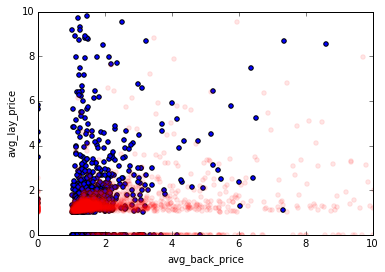

In [171]:
ax = avg1.loc[(avg1.correct_profit_loss == True).values].plot(kind='scatter', x='avg_back_price', y='avg_lay_price', xlim=(0, 10), ylim=(0, 10))
avg1.loc[(avg1.correct_profit_loss == False).values].plot(kind='scatter', x='avg_back_price', y='avg_lay_price', alpha=.1, ax=ax, color='r', xlim=(0, 10), ylim=(0, 10))

In [219]:
rf = RandomForestClassifier()
parameters = {'n_estimators': list(range(5, 100))}
gs = GridSearchCV(rf, parameters, scoring='roc_auc')
gs.fit(avg1[['BET_SIZE', 'avg_back_price', 'avg_lay_price', 'back_share', 'back_std', 'lay_std']], avg1['correct_profit_loss'])

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid={'n_estimators': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]},
       pre_dispatch='2*n_jobs', refit=True, score_func=None,
       scoring='roc_auc', verbose=0)

In [220]:
gs.best_params_

{'n_estimators': 87}

In [236]:
rf = RandomForestClassifier(n_estimators=87)
rf.fit(avg1[['BET_SIZE', 'avg_back_price', 'avg_lay_price', 'back_share', 'back_std', 'lay_std']], avg1['correct_profit_loss'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=87, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [223]:
pred = pd.Series(rf.predict(avg1[['BET_SIZE', 'avg_back_price', 'avg_lay_price', 'back_share', 'back_std', 'lay_std']]))

In [224]:
pred.shape

(4925,)

In [225]:
# in-sample error is so low???!
(pred == avg1['correct_profit_loss']).sum()

4924

In [237]:
to_submit = pd.DataFrame({
    'Account_ID': avg.index,
    'Prediction': rf.predict_proba(avg[['BET_SIZE', 'avg_back_price', 'avg_lay_price', 'back_share', 'back_std', 'lay_std']])[:, 1]})

In [127]:
to_submit = to_submit.set_index('Account_ID')

In [168]:
to_submit = to_submit.loc[submit.Account_ID.tolist()]

In [238]:
to_submit.head()

,Account_ID,Prediction
0,1000002,0.232837
1,1000004,0.034483
2,1000005,0.206897
3,1000010,0.022989
4,1000014,1.000000


In [239]:
to_submit.shape

(7374, 2)

In [170]:
to_submit = to_submit.fillna(0.2).reset_index()

In [132]:
to_submit.describe()

,Account_ID,Prediction
count,7374.000000,7374.000000
mean,1011060.910768,0.410796
std,6613.263866,0.323627
min,1000002.000000,0.000000
25%,1005685.750000,0.120000
50%,1010105.000000,0.300000
75%,1016848.750000,0.740000
max,1024189.000000,1.000000


In [240]:
to_submit.to_csv('prob_from_lay_back_with_makeup_data_87_estimators_quarter_games.csv', index=False)

In [107]:
# look at the new ones
pre_dat.ACCOUNT_ID.nunique()

6373

In [108]:
submit.Account_ID.nunique()

7374

In [109]:
newbies = submit.loc[~submit.Account_ID.isin(pre_dat.ACCOUNT_ID), 'Account_ID'].tolist()

In [110]:
newbie_dat = semi_final.loc[semi_final.Account_ID.isin(newbies), :]

In [111]:
newbie_dat.head()

,Account_ID,EVENT_ID,TRANSACTION_COUNT,STATUS_ID,INPLAY_BET,AVG_BET_SIZE,MAX_BET_SIZE,MIN_BET_SIZE,STDEV_BET_SIZE,MATCH
246,1000168,101187238,1,S,N,1261.438500,1261.43850,1261.438500,0.000000,South Africa v New Zealand
247,1000168,101187238,3,S,N,870.866790,1263.33540,85.929570,679.775573,South Africa v New Zealand
249,1000168,101187943,1,S,N,858.221000,858.22100,858.221000,0.000000,Australia v India
250,1000168,101187943,7,S,Y,622.984914,1467.46360,12.241438,548.878251,Australia v India
251,1000168,101187943,15,S,Y,187.865520,585.94803,19.880548,187.252063,Australia v India


In [112]:
# get the average bet
newbie_dat.loc[:, 'total'] = newbie_dat.loc[:, 'TRANSACTION_COUNT'] * newbie_dat.loc[:, 'AVG_BET_SIZE']

/Users/feizhan/miniconda/envs/py3_env/lib/python3.4/site-packages/pandas/core/indexing.py:249: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/feizhan/miniconda/envs/py3_env/lib/python3.4/site-packages/pandas/core/indexing.py:415: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [113]:
newbie_dat_by_account_event = newbie_dat.groupby(['Account_ID', 'EVENT_ID'])

In [114]:
new_game_total = newbie_dat_by_account_event['total'].sum()

In [115]:
new_game_avg = new_game_total.groupby(level=0).mean()

In [ ]:
rfg = RandomForestRegressor()
parameters = {'n_estimators': list(range(5, 100))}
gs = GridSearchCV(rfg, parameters, scoring='mean_squared_error')
gs.fit(avg.loc[:, ['BET_SIZE']], avg.loc[:, ['avg_back_price', 'avg_lay_price', 'back_share', 'back_std', 'lay_std']])

In [116]:
rfg = RandomForestRegressor(n_estimators=20)

In [117]:
rfg.fit(avg.loc[:, ['BET_SIZE']], avg.loc[:, ['avg_back_price', 'avg_lay_price', 'back_share', 'back_std', 'lay_std']])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=20, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [118]:
new_game_avg = pd.DataFrame(new_game_avg)

In [119]:
new_game_avg.head()

,total
Account_ID,
1000168,5955.568535
1000207,2000.000000
1000249,901.360094
1000274,228.645164
1000304,523.654400


In [120]:
make_up_data_np = rfg.predict(new_game_avg.iloc[:, [0]])

In [121]:
make_up_data = pd.DataFrame(
    {'BET_SIZE': new_game_avg.total,
     'avg_back_price': make_up_data_np[:, 0],
     'avg_lay_price': make_up_data_np[:, 1],
     'back_share': make_up_data_np[:, 2],
     'back_std': make_up_data_np[:, 3],
     'lay_std': make_up_data_np[:, 4]},
    index=newbies)

In [122]:
make_up_data.head()

,BET_SIZE,avg_back_price,avg_lay_price,back_share,back_std,lay_std
1013818,208.65900,1.855905,2.299692,0.533008,2.500325,3.091612
1014436,2000.00000,1.429258,0.143006,0.951423,5.456924,0.068212
1017244,233.04546,1.594828,1.182080,0.546469,34.449359,4.825068
1014050,315.24000,2.310473,1.625029,0.423921,1.799875,1.163053
1001853,300.00000,3.243624,1.232959,0.344763,22.055907,0.246411


In [234]:
avg = pd.concat([avg, make_up_data])

In [235]:
avg.shape

(7374, 7)

In [185]:
# to replace the bet size for whom in the pre_dat
semi_final.loc[:, 'total'] = semi_final.loc[:, 'TRANSACTION_COUNT'] * semi_final.loc[:, 'AVG_BET_SIZE']

In [186]:
semi_final_by_account_event = semi_final.groupby(['Account_ID', 'EVENT_ID'])

In [198]:
semi_avg = semi_final_by_account_event['total'].sum().groupby(level=0).mean()

In [206]:
semi_avg.head()

Account_ID
1000819      2748.042504
1009306    866866.915078
1005119      2483.285732
1018472      4946.171849
1018768       686.886275
Name: total, dtype: float64

In [205]:
semi_avg.shape

(6373,)

In [202]:
pre_acc = pre_dat.ACCOUNT_ID.unique()

In [204]:
semi_avg = semi_avg.loc[pre_acc]

In [203]:
len(pre_acc)

6373

In [207]:
semi_avg.loc[1000002]

6742.0909503333269

In [208]:
avg.loc[1000002]

BET_SIZE               2091.105
avg_back_price         2.131243
avg_lay_price                 0
back_share                    1
back_std               10.27379
correct_profit_loss       False
lay_std                       0
Name: 1000002, dtype: object

In [209]:
avg_test = avg.copy()

In [212]:
avg_test.loc[:, 'BET_SIZE'].update(semi_avg)

In [213]:
avg_test.loc[1000002]

BET_SIZE               6742.091
avg_back_price         2.131243
avg_lay_price                 0
back_share                    1
back_std               10.27379
correct_profit_loss       False
lay_std                       0
Name: 1000002, dtype: object

In [214]:
avg.loc[:, 'BET_SIZE'].update(semi_avg)

In [261]:
semi_avg_price = semi_final_by_account_event['total'].sum().groupby(level=0).mean()

In [262]:
semi_max = semi_final_by_account_event['MAX_BET_SIZE'].max().groupby(level=0).max()

In [263]:
semi_min = semi_final_by_account_event['MIN_BET_SIZE'].min().groupby(level=0).min()

In [264]:
semi_max.head()

Account_ID
1000002    758.760000
1000003     50.000000
1000004    943.100000
1000005     94.845000
1000006     47.669097
Name: MAX_BET_SIZE, dtype: float64

In [265]:
semi_final_stats = pd.concat([semi_avg, semi_max, semi_min], axis=1)

In [266]:
semi_final_stats.head()

,total,MAX_BET_SIZE,MIN_BET_SIZE
Account_ID,,,
1000002,6742.09095,758.760000,3.7724
1000003,NaN,50.000000,20.0000
1000004,943.10000,943.100000,943.1000
1000005,234.14945,94.845000,9.4310
1000006,NaN,47.669097,3.7724


In [267]:
semi_final_stats.shape

(12935, 3)

In [296]:
pre_dat.ACCOUNT_ID.nunique()

23003

In [316]:
pre_avg_price = pre_dat_by_account_event['BET_SIZE'].sum().groupby(level=0).mean()

In [317]:
pre_avg_price.name = 'BET_SIZE'

In [299]:
pre_max_price = pre_dat_by_account_event['BET_SIZE'].max().groupby(level=0).max()

In [311]:
pre_max_price.name = 'MAX_BET_SIZE'

In [300]:
pre_min_price = pre_dat_by_account_event['BET_SIZE'].min().groupby(level=0).min()

In [312]:
pre_min_price.name = 'MIN_BET_SIZE'

In [301]:
pre_avg_price.shape

(23003,)

In [302]:
avg.shape

(9003, 5)

In [303]:
pre_avg = pre_dat_by_account.apply(get_average_price)

In [304]:
pre_avg.shape

(23003, 5)

In [307]:
pre_avg.head()

,avg_back_price,avg_lay_price,back_share,back_std,lay_std
ACCOUNT_ID,,,,,
1011,6.399871,0.000000,0.999960,0.000000,0
1534,177.517239,0.000000,0.999711,21.213203,0
1887,0.000000,3.099992,0.000000,0.000000,0
2155,8.199834,0.000000,0.999960,0.000000,0
2166,15.425918,5.399938,0.511105,114.268456,0


In [306]:
pre_avg.loc[:, :] = pre_avg.loc[:, :].fillna(0)

In [318]:
pre_avg_totrain = pd.concat([pre_avg_price, pre_max_price, pre_min_price, pre_avg], axis=1)

In [319]:
pre_avg_totrain.head()

,BET_SIZE,MAX_BET_SIZE,MIN_BET_SIZE,avg_back_price,avg_lay_price,back_share,back_std,lay_std
ACCOUNT_ID,,,,,,,,
1011,49.4950,49.495000,49.495000,6.399871,0.000000,0.999960,0.000000,0
1534,6.9293,5.187076,1.742224,177.517239,0.000000,0.999711,21.213203,0
1887,397.9398,397.939800,397.939800,0.000000,3.099992,0.000000,0.000000,0
2155,49.4950,43.555600,5.939400,8.199834,0.000000,0.999960,0.000000,0
2166,178.1820,87.111200,3.959600,15.425918,5.399938,0.511105,114.268456,0


In [323]:
pre_avg_totrain.shape

(23003, 8)

In [466]:
rfg = RandomForestRegressor()
parameters = {'n_estimators': list(range(5, 100))}
gs = GridSearchCV(rfg, parameters, scoring='mean_squared_error', n_jobs=-1, verbose=1)
gs.fit(
    pre_avg_totrain.loc[:, ['BET_SIZE']],
    pre_avg_totrain.loc[:, ['avg_back_price', 'avg_lay_price', 'back_share', 'back_std', 'lay_std']])

Fitting 3 folds for each of 95 candidates, totalling 285 fits


[Parallel(n_jobs=-1)]: Done   1 jobs       | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  50 jobs       | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 200 jobs       | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 285 out of 285 | elapsed:  2.2min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, loss_func=None, n_jobs=-1,
       param_grid={'n_estimators': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]},
       pre_dispatch='2*n_jobs', refit=True, score_func=None,
       scoring='mean_squared_error', verbose=1)

In [467]:
gs.best_params_

{'n_estimators': 54}

In [468]:
rfg = RandomForestRegressor(n_estimators=54)
rfg.fit(
    pre_avg_totrain.loc[:, ['BET_SIZE']],
    pre_avg_totrain.loc[:, ['avg_back_price', 'avg_lay_price', 'back_share', 'back_std', 'lay_std']])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=54, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [331]:
# find the 4925, 1448, 1000 punters
pre_dat_in_submit.ACCOUNT_ID.nunique()

6373

In [332]:
quarter_in_submit = pre_dat_in_submit.loc[pre_dat_in_submit.EVENT_ID.isin([101183237, 101183757, 101183885, 101184013])]

In [334]:
the4925 = quarter_in_submit.ACCOUNT_ID.tolist()

In [338]:
the1001 = submit.loc[~submit.Account_ID.isin(pre_dat_in_submit.ACCOUNT_ID), 'Account_ID'].tolist()

In [342]:
the1448 = pre_dat_in_submit.loc[~pre_dat_in_submit.ACCOUNT_ID.isin(quarter.ACCOUNT_ID), 'ACCOUNT_ID'].tolist()

In [343]:
# test how good the classifier model on the 4925 but with their pre-semi data
the4925_pre_dat = pre_dat_in_submit.loc[pre_dat_in_submit.ACCOUNT_ID.isin(the4925), :]

In [345]:
the4925_avgs = the4925_pre_dat.groupby('ACCOUNT_ID').apply(get_average_price)

In [347]:
the4925_avgs.head()

,avg_back_price,avg_lay_price,back_share,back_std,lay_std
ACCOUNT_ID,,,,,
1000002,2.131243,0.000000,1.000000,10.273789,NaN
1000004,2.009621,1.226126,0.529321,9.114344,0.183689
1000005,1.164510,1.081237,0.459241,0.533567,0.223361
1000010,4.900702,1.240785,0.434367,58.987752,0.264042
1000014,1.499985,0.000000,0.999980,0.000000,NaN


In [348]:
the4925_betsize = the4925_pre_dat.groupby(['ACCOUNT_ID', 'EVENT_ID'])['BET_SIZE'].sum().groupby(level=0).mean()

In [355]:
the4925_res = (quarter_in_submit.groupby(['ACCOUNT_ID'])['correct_profit_loss'].sum() > 0).apply(lambda x: int(x))

In [358]:
the4925_pre_semi = pd.concat([the4925_avgs, the4925_betsize, the4925_res], axis=1).fillna(0)

In [359]:
the4925_pre_semi.head()

,avg_back_price,avg_lay_price,back_share,back_std,lay_std,BET_SIZE,correct_profit_loss
ACCOUNT_ID,,,,,,,
1000002,2.131243,0.000000,1.000000,10.273789,0.000000,2091.105015,0
1000004,2.009621,1.226126,0.529321,9.114344,0.183689,259.069892,0
1000005,1.164510,1.081237,0.459241,0.533567,0.223361,5599.937000,0
1000010,4.900702,1.240785,0.434367,58.987752,0.264042,932.061019,0
1000014,1.499985,0.000000,0.999980,0.000000,0.000000,100.000000,1


In [361]:
pred = pd.Series(rf.predict(the4925_pre_semi[['BET_SIZE', 'avg_back_price', 'avg_lay_price', 'back_share', 'back_std', 'lay_std']]))
(pred == the4925_pre_semi['correct_profit_loss']).sum() / 4925

0.80345177664974621

In [362]:
the4925_res.value_counts()

0    2780
1    2145
dtype: int64

In [364]:
# if I could this auc in the final leadboarder ......
roc_auc_score(the4925_res, pred)

0.80055508041119561

In [366]:
# now to make the prediction data first pre-semi for the 4925
the4925_to_pred = pd.concat([the4925_avgs, the4925_betsize], axis=1).fillna(0)

In [368]:
the4925_to_pred.head()

,avg_back_price,avg_lay_price,back_share,back_std,lay_std,BET_SIZE
ACCOUNT_ID,,,,,,
1000002,2.131243,0.000000,1.000000,10.273789,0.000000,2091.105015
1000004,2.009621,1.226126,0.529321,9.114344,0.183689,259.069892
1000005,1.164510,1.081237,0.459241,0.533567,0.223361,5599.937000
1000010,4.900702,1.240785,0.434367,58.987752,0.264042,932.061019
1000014,1.499985,0.000000,0.999980,0.000000,0.000000,100.000000


In [369]:
the1448_pre_semi = pre_dat_in_submit.loc[pre_dat_in_submit.ACCOUNT_ID.isin(the1448), :]

In [375]:
the1448_avgs = the1448_pre_semi.groupby('ACCOUNT_ID').apply(get_average_price)

In [376]:
the1448_avgs.head()

,avg_back_price,avg_lay_price,back_share,back_std,lay_std
ACCOUNT_ID,,,,,
1000019,3.978041,2.244549,0.513622,13.841371,0.305090
1000063,1.615418,1.318645,0.617446,0.665000,0.325269
1000072,2.423797,7.402349,0.602670,2.477745,27.894228
1000082,4.599952,0.000000,0.999979,NaN,NaN
1000104,1.619938,1.474498,0.021404,NaN,0.634445


In [377]:
the1448_betsize = the1448_pre_semi.groupby(['ACCOUNT_ID'])['BET_SIZE'].sum().groupby(level=0).mean()

In [378]:
the1448_betsize.head()

ACCOUNT_ID
1000019     268.60406
1000063     949.19800
1000072     565.05982
1000082      95.24000
1000104    1214.73000
Name: BET_SIZE, dtype: float64

In [379]:
the1448_to_pred = pd.concat([the1448_avgs, the1448_betsize], axis=1).fillna(0)

In [380]:
the1448_to_pred.head()

,avg_back_price,avg_lay_price,back_share,back_std,lay_std,BET_SIZE
ACCOUNT_ID,,,,,,
1000019,3.978041,2.244549,0.513622,13.841371,0.305090,268.60406
1000063,1.615418,1.318645,0.617446,0.665000,0.325269,949.19800
1000072,2.423797,7.402349,0.602670,2.477745,27.894228,565.05982
1000082,4.599952,0.000000,0.999979,0.000000,0.000000,95.24000
1000104,1.619938,1.474498,0.021404,0.000000,0.634445,1214.73000


In [381]:
# the now the 1001
the1001_semi = semi_final.loc[semi_final.Account_ID.isin(the1001), :]

In [390]:
the1001_betsize = the1001_semi.groupby(['Account_ID', 'EVENT_ID'])['total'].sum().groupby(level=0).mean()
the1001_betsize.name = 'BET_SIZE'

In [391]:
the1001_betsize.head()

Account_ID
1000168    5955.568535
1000207    2000.000000
1000249     901.360094
1000274     228.645164
1000304     523.654400
Name: BET_SIZE, dtype: float64

In [388]:
the1001_max = the1001_semi.groupby(['Account_ID', 'EVENT_ID'])['MAX_BET_SIZE'].max().groupby(level=0).max()

In [389]:
the1001_max.head()

Account_ID
1000168    1467.463600
1000207    1000.000000
1000249     416.012351
1000274     125.658644
1000304     523.654400
Name: MAX_BET_SIZE, dtype: float64

In [392]:
the1001_min = the1001_semi.groupby(['Account_ID', 'EVENT_ID'])['MIN_BET_SIZE'].min().groupby(level=0).min()

In [393]:
the1001_min.head()

Account_ID
1000168      12.241438
1000207    1000.000000
1000249     100.550185
1000274     102.986520
1000304     523.654400
Name: MIN_BET_SIZE, dtype: float64

In [394]:
the1001_to_makeup = pd.concat([the1001_betsize, the1001_max, the1001_min], axis=1)

In [395]:
the1001_to_makeup.head()

,BET_SIZE,MAX_BET_SIZE,MIN_BET_SIZE
Account_ID,,,
1000168,5955.568535,1467.463600,12.241438
1000207,2000.000000,1000.000000,1000.000000
1000249,901.360094,416.012351,100.550185
1000274,228.645164,125.658644,102.986520
1000304,523.654400,523.654400,523.654400


In [469]:
the1001_makeup = rfg.predict(the1001_to_makeup[['BET_SIZE']])

In [470]:
the1001_makeup = pd.DataFrame(
    the1001_makeup,
    columns=['avg_back_price', 'avg_lay_price', 'back_share', 'back_std', 'lay_std'],
    index=the1001_betsize.index)

In [471]:
the1001_makeup.head()

,avg_back_price,avg_lay_price,back_share,back_std,lay_std
Account_ID,,,,,
1000168,0.270664,1.513560,0.075967,0.981323,0.110005
1000207,3.044383,1.062965,0.893958,0.033293,0.001044
1000249,1.424002,1.330192,0.468835,14.240980,2.708556
1000274,2.953620,0.790634,0.864881,1.748544,0.326312
1000304,2.341260,1.143370,0.243351,17.022908,0.161918


In [472]:
the1001_to_pred = pd.concat([the1001_makeup, the1001_betsize], axis=1)

In [406]:
the1001_to_pred.head()

,avg_back_price,avg_lay_price,back_share,back_std,lay_std,BET_SIZE
Account_ID,,,,,,
1000168,2.639751,2.161866,0.441398,0.269713,0.206835,5955.568535
1000207,8.069098,4.301904,0.524399,0.035120,0.013436,2000.000000
1000249,1.331277,1.063001,0.518934,0.287000,0.034495,901.360094
1000274,1.651718,0.956855,0.535204,0.116205,0.109579,228.645164
1000304,1.303822,0.121444,0.899997,0.018149,0.000000,523.654400


In [407]:
# put three pieces together to predict
to_pred = pd.concat([the4925_to_pred, the1448_to_pred, the1001_to_pred])
to_pred.shape

(7374, 6)

In [416]:
to_pred.isnull().any()

avg_back_price    False
avg_lay_price     False
back_share        False
back_std          False
lay_std           False
BET_SIZE          False
dtype: bool

In [428]:
rf.n_estimators

83

In [429]:
to_submit = pd.DataFrame({
    'Account_ID': to_pred.index,
    'Prediction': rf.predict_proba(to_pred[['BET_SIZE', 'avg_back_price', 'avg_lay_price', 'back_share', 'back_std', 'lay_std']])[:, 1]})

In [430]:
to_submit.shape

(7374, 2)

In [431]:
to_submit.head()

,Account_ID,Prediction
0,1000002,0.787869
1,1000004,0.192771
2,1000005,0.759036
3,1000010,0.180723
4,1000014,0.963855


In [432]:
to_submit.to_csv('three_pieces_all_old_data.csv', index=False)

In [433]:
to_submit.describe()

,Account_ID,Prediction
count,7374.000000,7374.000000
mean,1011060.910768,0.439552
std,6613.263866,0.343448
min,1000002.000000,0.000000
25%,1005685.750000,0.096386
50%,1010105.000000,0.407096
75%,1016848.750000,0.763347
max,1024189.000000,1.000000


In [417]:
# now quarter data for the 4925
the4925_avgs = quarter_in_submit.groupby('ACCOUNT_ID').apply(get_average_price).fillna(0)

In [418]:
the4925_avgs.shape

(4925, 5)

In [419]:
the4925_avgs.head()

,avg_back_price,avg_lay_price,back_share,back_std,lay_std
ACCOUNT_ID,,,,,
1000002,1.977567,0.000000,1.000000,16.328730,0.000000
1000004,0.000000,1.284071,0.000000,0.000000,0.111071
1000005,1.118681,1.051863,0.427161,0.697832,0.027080
1000010,0.000000,1.124129,0.000000,0.000000,0.080829
1000014,1.499985,0.000000,0.999980,0.000000,0.000000


In [415]:
the4925_betsize = quarter_in_submit.groupby(['ACCOUNT_ID', 'EVENT_ID'])['BET_SIZE'].sum().groupby(level=0).mean()

In [420]:
the4925_betsize.head()

ACCOUNT_ID
1000002    3314.478695
1000004     461.931000
1000005     996.691000
1000010    1163.724400
1000014     100.000000
Name: BET_SIZE, dtype: float64

In [421]:
the4925_to_pred = pd.concat([the4925_avgs, the4925_betsize], axis=1)

In [422]:
the4925_to_pred.head()

,avg_back_price,avg_lay_price,back_share,back_std,lay_std,BET_SIZE
ACCOUNT_ID,,,,,,
1000002,1.977567,0.000000,1.000000,16.328730,0.000000,3314.478695
1000004,0.000000,1.284071,0.000000,0.000000,0.111071,461.931000
1000005,1.118681,1.051863,0.427161,0.697832,0.027080,996.691000
1000010,0.000000,1.124129,0.000000,0.000000,0.080829,1163.724400
1000014,1.499985,0.000000,0.999980,0.000000,0.000000,100.000000


In [435]:
the4925_quarter_res = (quarter_in_submit.groupby('ACCOUNT_ID')['correct_profit_loss'].sum() > 0).apply(lambda x: int(x))

In [436]:
the4925_quarter_res.shape

(4925,)

In [437]:
the4925_quarter_res.head()

ACCOUNT_ID
1000002    0
1000004    0
1000005    0
1000010    0
1000014    1
Name: correct_profit_loss, dtype: int64

In [438]:
pred = pd.Series(rf.predict(the4925_to_pred[['BET_SIZE', 'avg_back_price', 'avg_lay_price', 'back_share', 'back_std', 'lay_std']]))
(pred == the4925_quarter_res).sum() / 4925

1.0

In [439]:
the1001_to_pred.head()

,avg_back_price,avg_lay_price,back_share,back_std,lay_std,BET_SIZE
Account_ID,,,,,,
1000168,2.639751,2.161866,0.441398,0.269713,0.206835,5955.568535
1000207,8.069098,4.301904,0.524399,0.035120,0.013436,2000.000000
1000249,1.331277,1.063001,0.518934,0.287000,0.034495,901.360094
1000274,1.651718,0.956855,0.535204,0.116205,0.109579,228.645164
1000304,1.303822,0.121444,0.899997,0.018149,0.000000,523.654400


In [539]:
# put three pieces together to predict
to_pred = pd.concat([the4925_to_pred, the1448_to_pred, the1001_to_pred])
to_pred.shape

(7374, 6)

In [544]:
to_submit = pd.DataFrame({
    'Account_ID': to_pred.index,
    'Prediction': rf.predict(to_pred[['BET_SIZE', 'avg_back_price', 'avg_lay_price', 'back_share', 'back_std', 'lay_std']])})

In [442]:
to_submit.head()

,Account_ID,Prediction
0,1000002,0.309455
1,1000004,0.000000
2,1000005,0.301205
3,1000010,0.000000
4,1000014,0.963855


In [546]:
to_submit.to_csv('three_pieces_updated_betsize_regression.csv', index=False)

In [545]:
to_submit.describe()

,Account_ID,Prediction
count,7374.000000,7374.000000
mean,1011060.910768,363.289076
std,6613.263866,10782.184559
min,1000002.000000,-485957.143768
25%,1005685.750000,-322.859781
50%,1010105.000000,-50.241058
75%,1016848.750000,148.612167
max,1024189.000000,174635.012538


In [542]:
# now everyone use the updated betsize
to_pred.head()

,avg_back_price,avg_lay_price,back_share,back_std,lay_std,BET_SIZE
1000002,1.977567,0.000000,1.000000,16.328730,0.000000,6742.090950
1000004,0.000000,1.284071,0.000000,0.000000,0.111071,943.100000
1000005,1.118681,1.051863,0.427161,0.697832,0.027080,234.149450
1000010,0.000000,1.124129,0.000000,0.000000,0.080829,900.377670
1000014,1.499985,0.000000,0.999980,0.000000,0.000000,181.593333


In [446]:
semi_betsize = semi_final.loc[semi_final.Account_ID.isin(submit.Account_ID), :].groupby(['Account_ID', 'EVENT_ID'])['total'].sum().groupby(level=0).mean()

In [447]:
semi_betsize.shape

(7374,)

In [448]:
semi_betsize.head()

Account_ID
1000002    6742.090950
1000004     943.100000
1000005     234.149450
1000010     900.377670
1000014     181.593333
Name: total, dtype: float64

In [453]:
semi_betsize.name = 'BET_SIZE'

In [541]:
to_pred.update(semi_betsize)

In [494]:
check_loc = 1000004

In [498]:
check_loc in the1001

False

In [499]:
check_loc in the4925

True